### <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА </center>


HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.



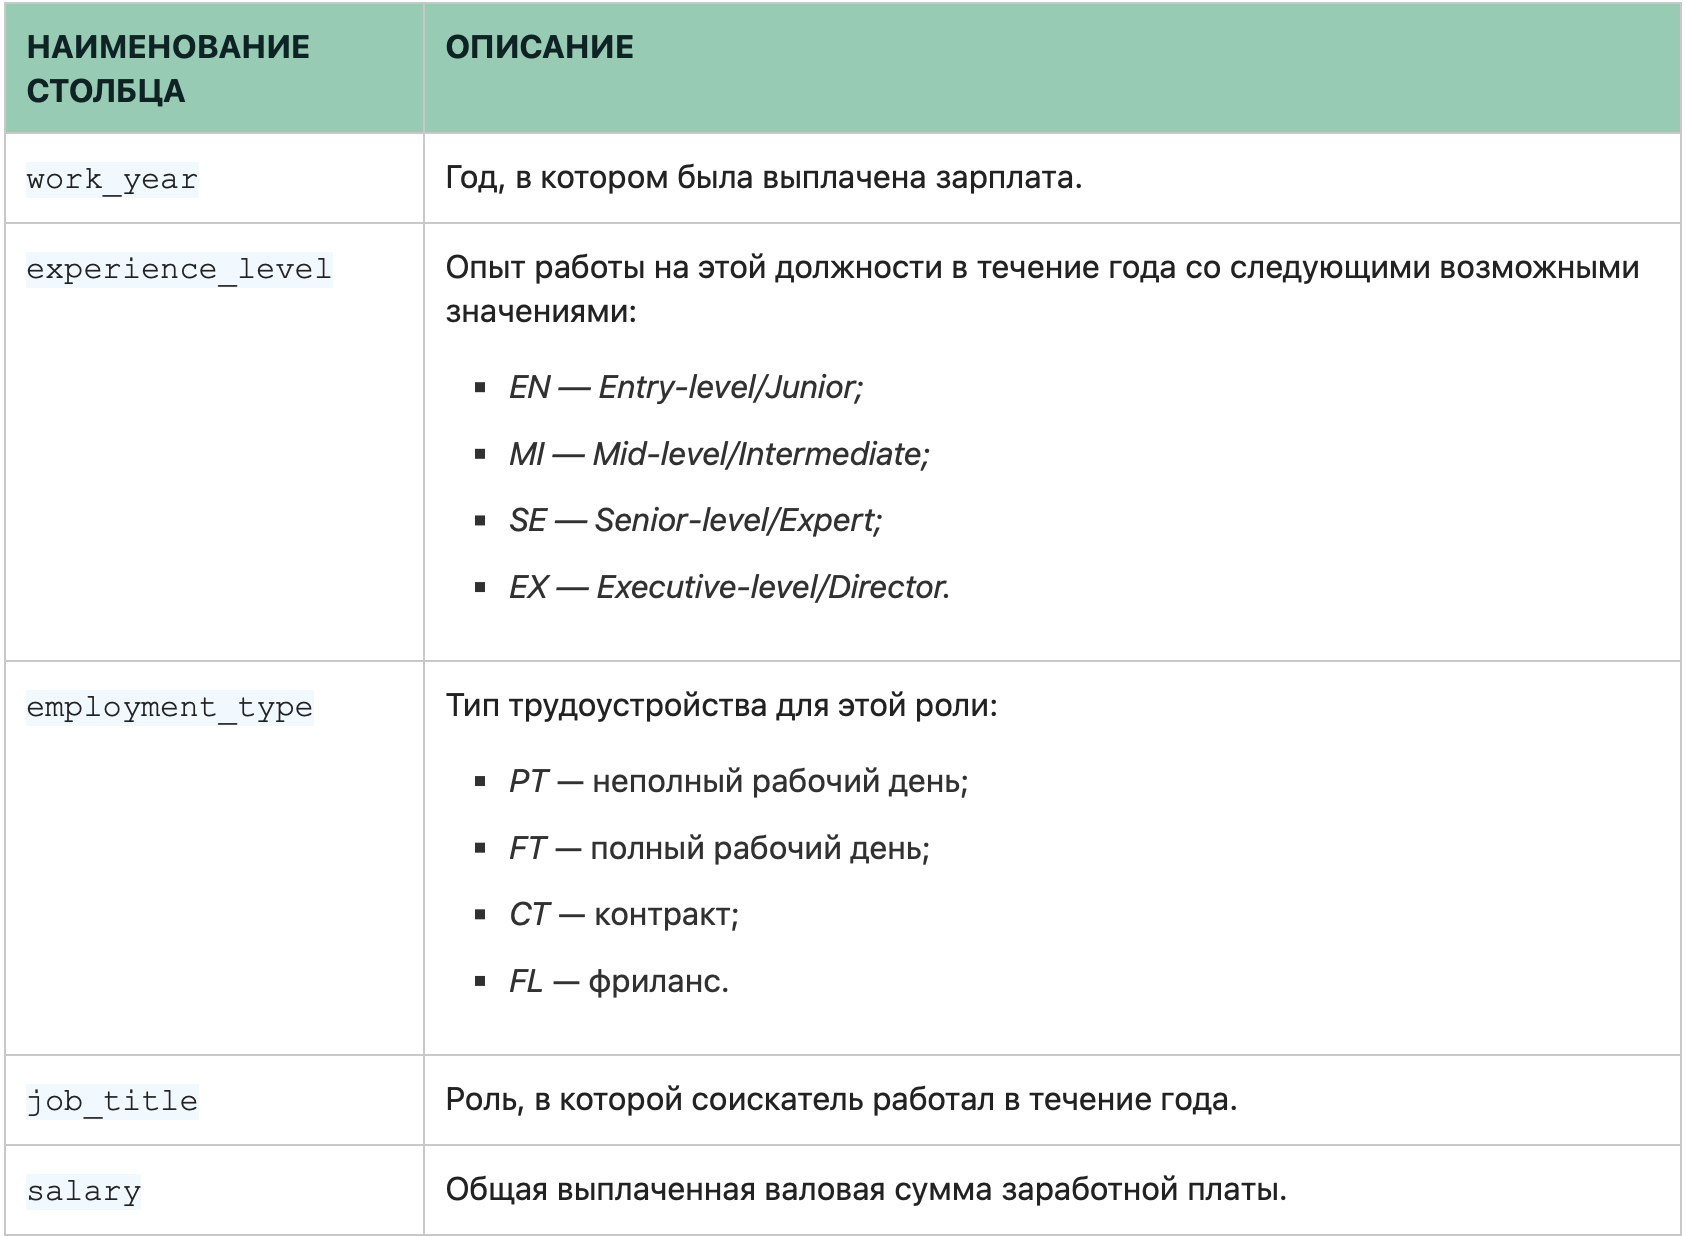


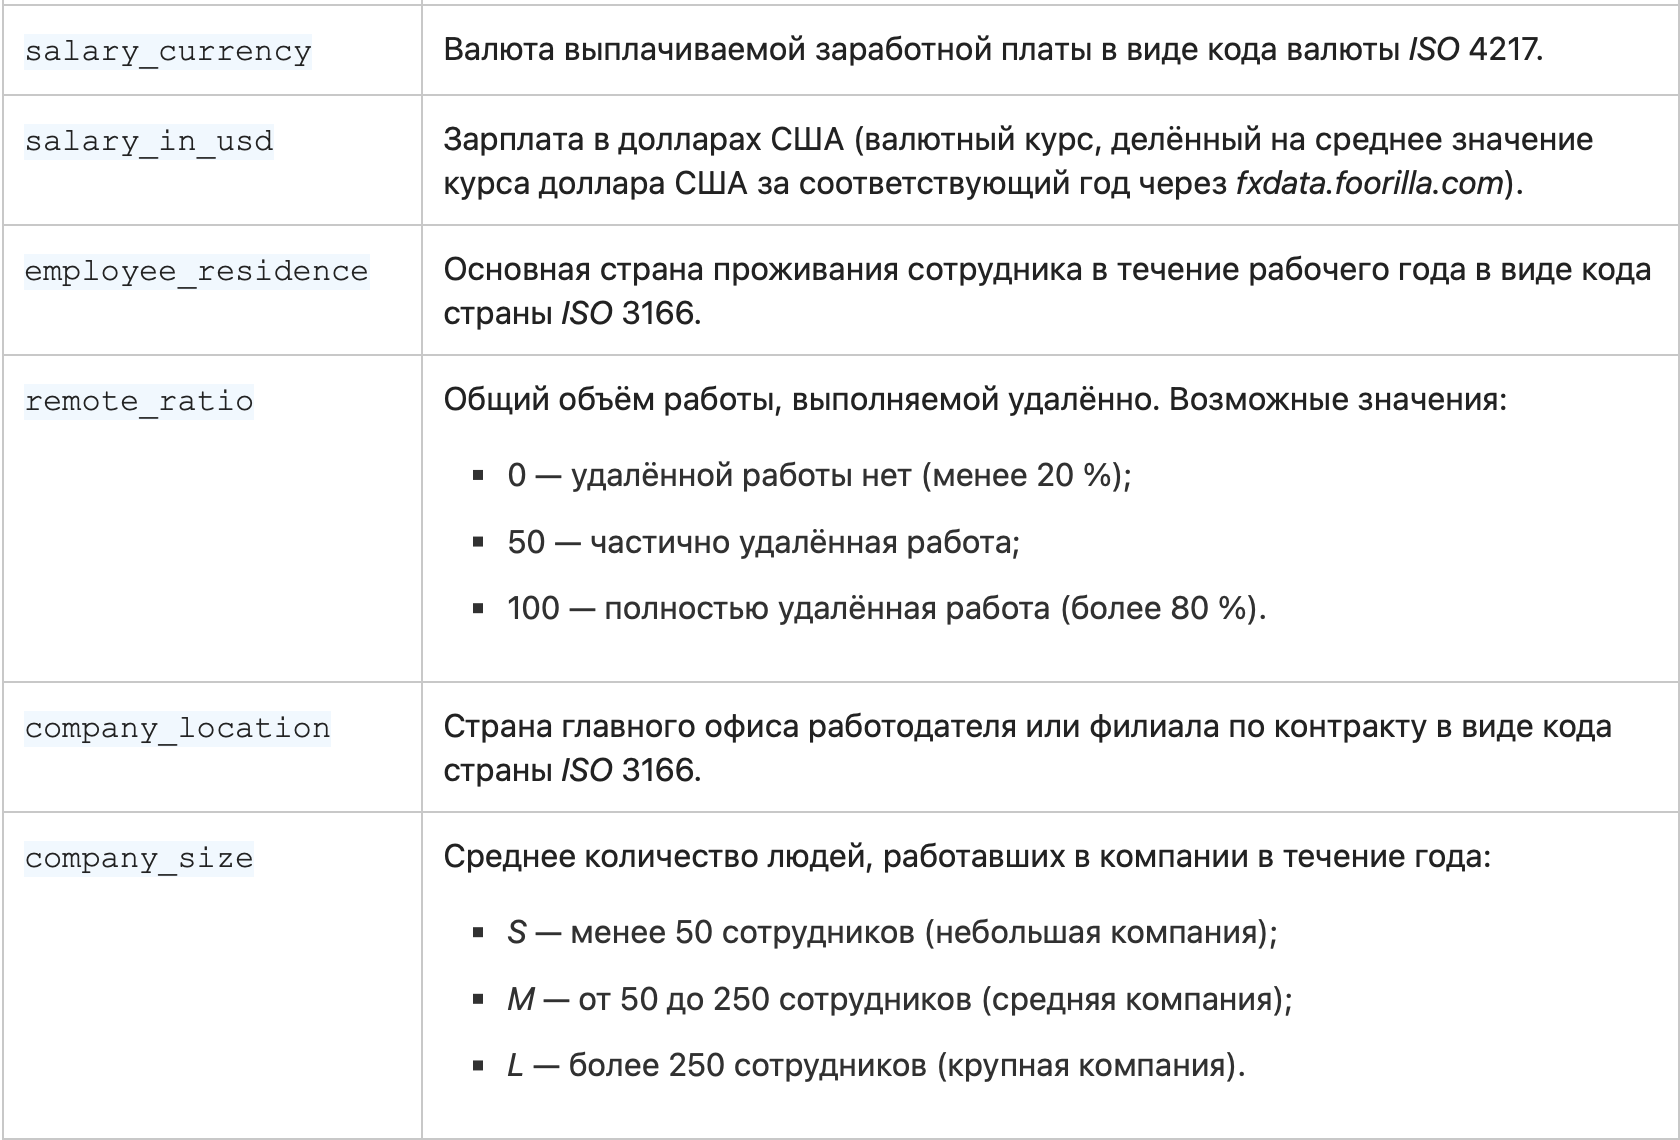

Исследовать данные и сделать выводы по полученным результатам. Подкрепить выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе анализа требуется:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если в данных будут обнаружены интересные закономерности, также отметить их в анализе.

Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:

Тесты для количественного признака:
- для одной выборки;
- для двух выборок;
- для нескольких выборок;

Тест для категориальных признаков.

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

/var/folders/4p/61221tbs1lq96mmqjjf1m7m40000gn/T/ipykernel_90176/663763331.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy import stats


In [2]:
data=pd.read_csv('/ds_salaries.csv', index_col=[0])

In [3]:
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [4]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


### Описательный анализ данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В Датасете 607 данных, без пропусков.
Имеется 5 числовых столбцов и 7 категориальных.
Проведем исследование данных на дубликаты.

In [6]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


In [7]:
data.salary.describe().round(2).to_frame()

,salary
count,565.00
mean,338115.99
std,1599878.79
min,4000.00
25%,67000.00
50%,110925.00
75%,165000.00
max,30400000.00


Максимальное значение уровня заработной платы более 3 млн. Минимальное значение - 4000. Столбец salary в исходных данных указывает на зарплату в местной валюте. Поэтому считаем правильным удалить столбец salary  и salary_currency.

In [8]:
data=data.drop(['salary', 'salary_currency'], axis=1)

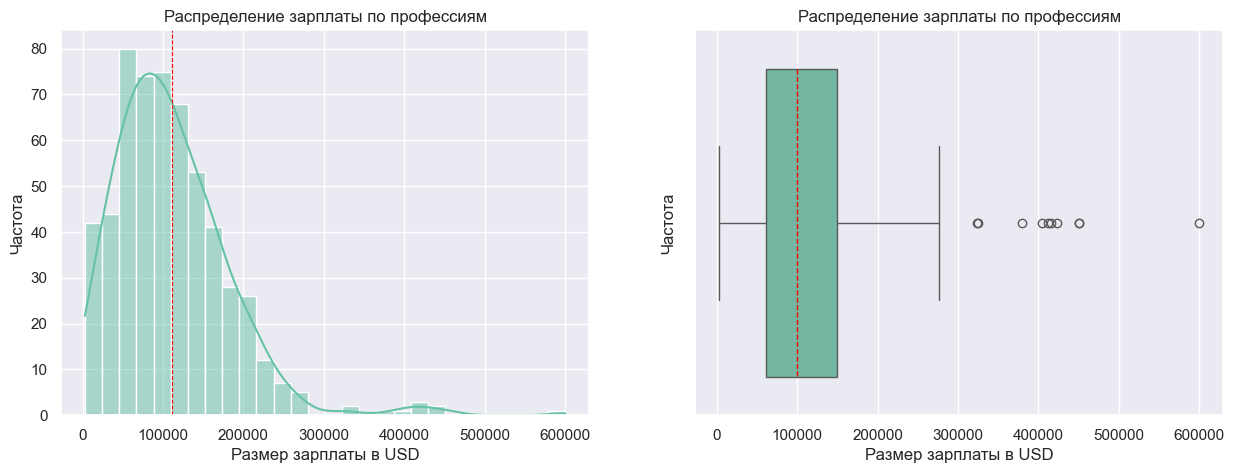

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплаты по профессиям')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Частота')
axes[1].set(xlabel='Размер зарплаты в USD')
axes[1].set_title('Распределение зарплаты по профессиям')

plt.show()

Средняя зарплата находится в районе 100000. Верхняя граница распределения зарплаты находится в пределах 300000 USD. В данных есть вакансии с высокой зарплатой, которые отличаются от основных распределений зарплаты. 

In [10]:
data.salary_in_usd.describe().round(2).to_frame()

,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


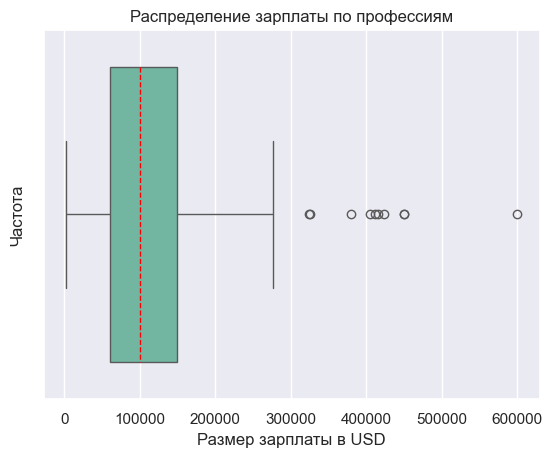

In [11]:


axes=sns.boxplot(data['salary_in_usd'], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Частота')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Распределение зарплаты по профессиям')

plt.show()

Провели исследование на выбросы в зарплате и успешно их удалили.

### Анализ роста заработной платы по годам. 

In [12]:
data.job_title.value_counts().head()

job_title
Data Scientist               130
Data Engineer                121
Data Analyst                  82
Machine Learning Engineer     39
Research Scientist            16
Name: count, dtype: int64

Из представленных профессий преобладают Data Scientist и Data Engineer.

In [13]:
data_ds=data[data.job_title=='Data Scientist']
data_de=data[data.job_title=='Data Engineer']

In [14]:
data_ds.groupby('work_year')['salary_in_usd'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


Проанализировав заработную плату у Data Scientist мы наблюдаем рост с каждым годом. При этом отметим, что средняя зарплата в 2020 и 2021 году примерно одинаковая. В 2021 году минимальная зарплата составила около 3000 USD, делаем предположение, что это похоже на выброс, поэтому необходимо построить boxplot отдельно на 2021 год, чтобы проверить данное предположение. 

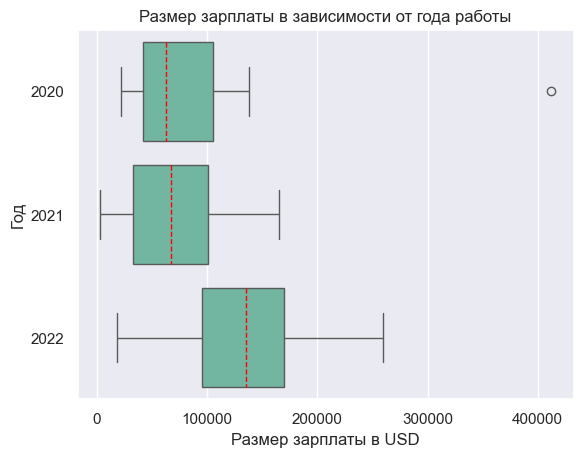

In [15]:
axes=sns.boxplot(data_ds, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Год')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Размер зарплаты в зависимости от года работы')

plt.show()

График не подтвердил данного предположения о выбросах в 2021 году. Все находится в нормальных пределах boxplot.

Проведем такой же анализ для профессии Data Engineer, чтобы сравнить результаты.

In [16]:
data_de.groupby('work_year')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,11.0,88162.00,46473.12,33511.0,51320.5,74130.0,111436.0,188000.0
2021,31.0,79434.87,49246.33,4000.0,29452.0,76833.0,110887.5,200000.0
2022,79.0,124651.78,57846.84,25000.0,78526.0,115000.0,160040.0,324000.0


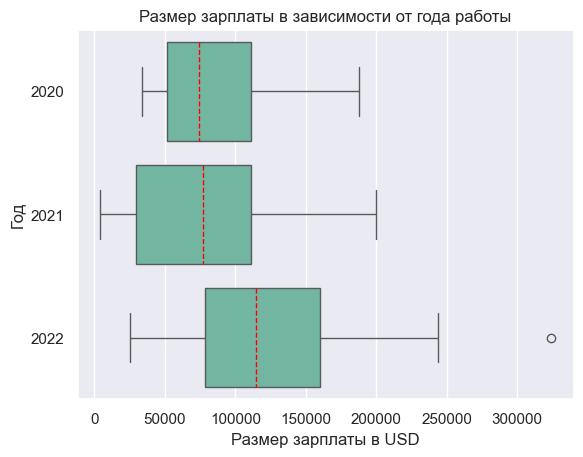

In [17]:
axes=sns.boxplot(data_de, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Год')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Размер зарплаты в зависимости от года работы')

plt.show()

Такие же тенденции наблюдаются у данной прфессии, как у DS. Зарплаты за 2020 и 2021 года примерно одинаковые. Наблюдается рост зарплаты по годам. 

In [18]:
data.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_in_usd', 'employee_residence', 'remote_ratio',
       'company_location', 'company_size'],
      dtype='object')

### Зависимость зарплаты от опыта работы. 

In [19]:
data_ds.groupby('experience_level')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,59.0,81891.76,47257.88,2859.0,41339.0,76958.0,118529.50,200000.0
SE,49.0,150710.86,62918.63,20171.0,104890.0,144000.0,180000.00,412000.0


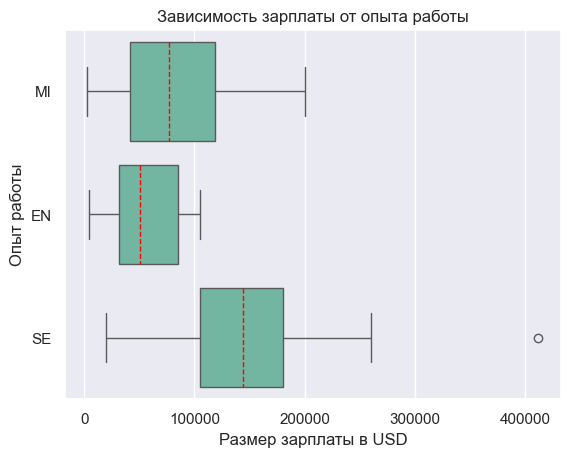

In [20]:
axes=sns.boxplot(data_ds, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Опыт работы')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от опыта работы')

plt.show()

Видим, что с увеличением опыта - зарплата увеличивается. 

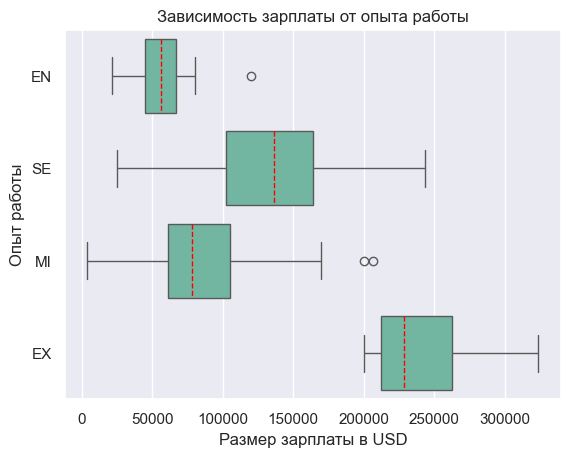

In [21]:
axes=sns.boxplot(data_de, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Опыт работы')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от опыта работы')

plt.show()

По результатам графика наблюдаются выбросы у специалистов Junior и Mid-level. Также видим, что у Директора самая высокая зарплата. По итогу прослеживается та же тенденция по зависимости зарплаты от опыта работы, чем больше опыт - тем выше зарплата. 

### Зависимость зарплаты от размера компании.

In [22]:
data_ds.groupby('company_size')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,43.0,102743.42,73254.10,13400.0,45240.5,90734.0,135000.0,412000.0
M,66.0,120080.58,56347.79,4000.0,80000.0,119529.5,157500.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


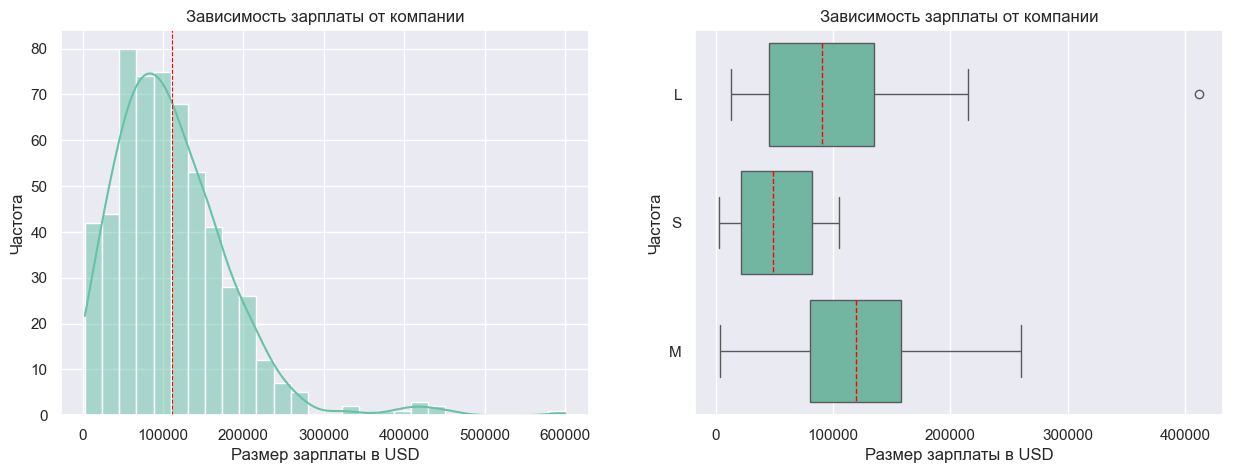

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты в USD', ylabel='Частота')
axes[0].set_title('Зависимость зарплаты от компании')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_ds,x='salary_in_usd', y='company_size', ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Частота')
axes[1].set(xlabel='Размер зарплаты в USD')
axes[1].set_title('Зависимость зарплаты от компании')

plt.show()

In [24]:
data_de.groupby('company_size')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,34.0,96875.62,52008.29,20000.0,58653.00,93141.0,112968.00,209100.0
M,81.0,118369.48,60222.08,4000.0,76940.00,110500.0,156600.00,324000.0
S,6.0,66342.50,28862.47,33511.0,47516.75,65511.0,74130.25,115000.0


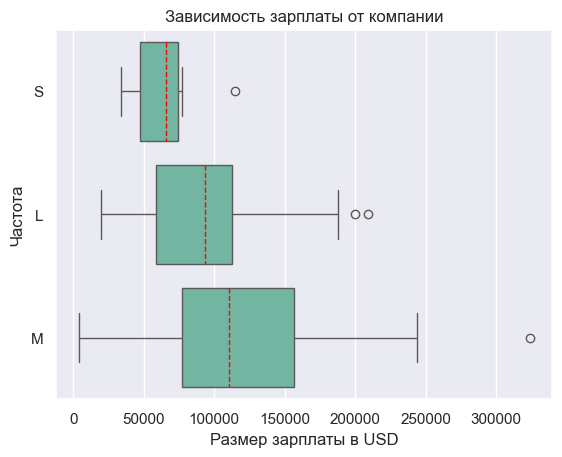

In [25]:
axes=sns.boxplot(data_de,x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Частота')
axes.set(xlabel='Размер зарплаты в USD')
axes.set_title('Зависимость зарплаты от компании')

plt.show()

Исходя из данных графика размер зарплаты у специалистов DS и DE - не зависит от размера компании. Видим, что в копании среднего размера зарплаты выше (в диапазоне от 100000-150000), чем в компании бОльшего размера (ниже 100000).

### Зависимость от типа занятости. 

In [26]:
data_ds.groupby('employment_type')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,127.0,104031.94,64309.23,2859.0,50660.50,100000.0,140850.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


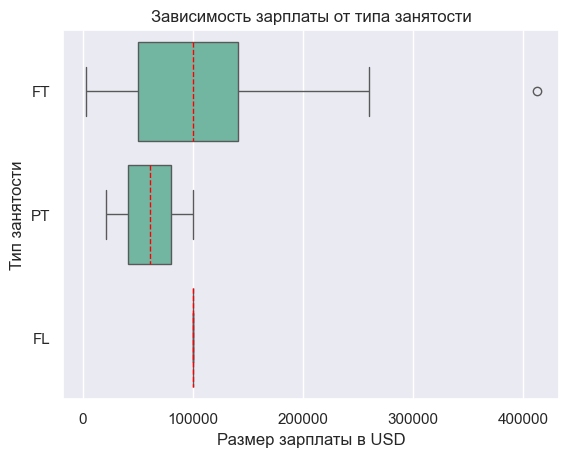

In [27]:
axes=sns.boxplot(data_ds, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Тип занятости')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от типа занятости')

plt.show()

Наиболее высокая зарплата у специалистов, которые работают полный рабочий день. 

In [28]:
data_de.groupby('employment_type')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,20000.00,NaN,20000.0,20000.0,20000.0,20000.0,20000.0
FT,118.0,111314.03,57998.93,4000.0,68645.0,103136.0,150000.0,324000.0
PT,2.0,62349.00,10453.87,54957.0,58653.0,62349.0,66045.0,69741.0


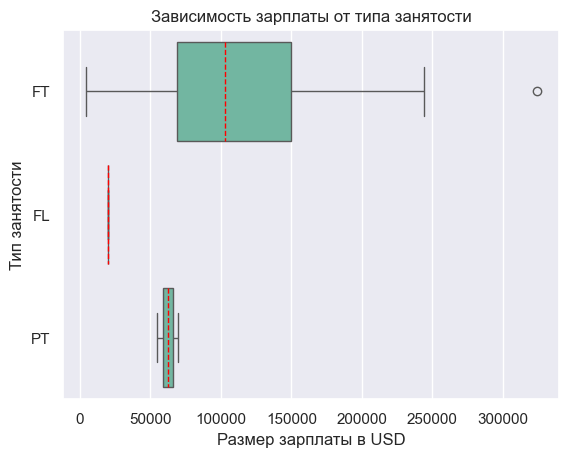

In [29]:
axes=sns.boxplot(data_de, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Тип занятости')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от типа занятости')

plt.show()

Видим, что основная часть специалистов DS и DE оформлена на полный рбочий день, и зарплаты у данного графика выше. Но также видим, что у специалистов DS есть сотрудник, у которого медианная зарплата фриланса равна медианной зарплате полной занятости. 

### Зависимость зарплаты от объема работы, выполняемой удаленно. 

In [30]:
data_ds.groupby('remote_ratio')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,38.0,98444.97,58647.60,2859.0,49781.25,93582.0,139050.0,215300.0
50,24.0,73827.83,36204.18,20171.0,47783.75,62726.0,102250.0,147000.0
100,68.0,116484.54,70908.36,5679.0,64420.00,111500.0,160000.0,412000.0


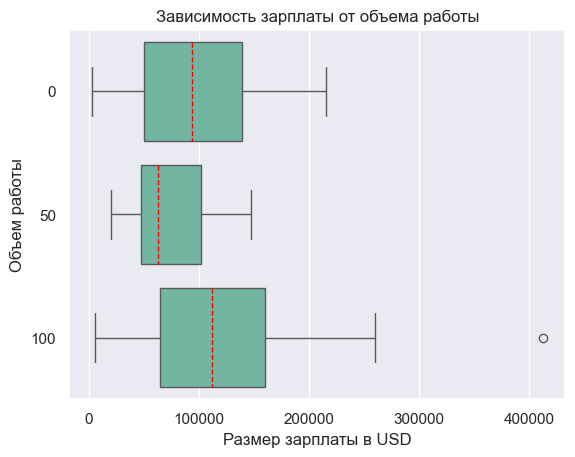

In [31]:
axes=sns.boxplot(data_ds, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Объем работы')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от объема работы')

plt.show()

In [32]:
data_de.groupby('remote_ratio')['salary_in_usd'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,27.0,101543.74,55463.01,12103.0,64669.0,98158.0,134160.00,220110.0
50,12.0,65530.42,25557.86,21637.0,53192.5,68080.5,74805.75,112872.0
100,82.0,118923.27,59542.73,4000.0,76940.0,110250.0,154900.00,324000.0


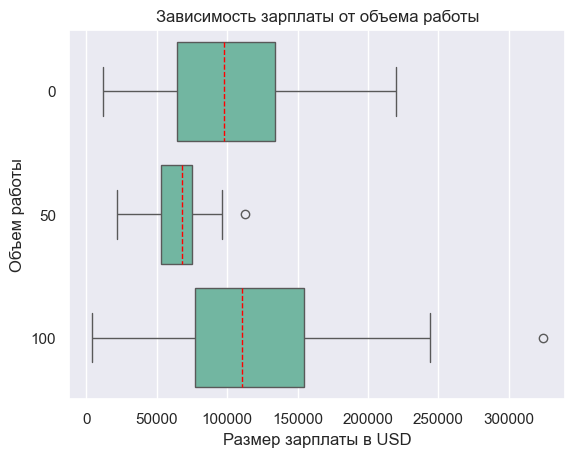

In [33]:
axes=sns.boxplot(data_de, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes.set(ylabel='Объем работы')
axes.set(xlabel='Размер зарплаты в USD')
plt.title('Зависимость зарплаты от объема работы')

plt.show()

Наблюдается самый высокий уровень запрлаты у тех сотрудников, у которых объем выполняемой работы удаленно составляет более 80%. При отсутствии удаленной работы зарплата также является высокой. Также у сотрудников, у которых объем работы составляет 50% - зарплата находится в диапазоне 630000-68000. Но при этом у специалистов DE запрлата выше, чем у DS.

### <center> СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАННЫХ </center>

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

In [34]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### 1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер eжегодных зарплат у DS по всем трем годам не увеличивается ($μ_1$) ($μ_2$) ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): размер eжегодных зарплат у DS по всем трем годам увеличивается ($μ_1$) ($μ_2$) ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [35]:
# значения запрлаты за 2020, 2021, 2022 года
charges_2020 = data_ds.loc[data_ds['work_year']== 2020, 'salary_in_usd']
charges_2021 = data_ds.loc[data_ds['work_year']== 2021, 'salary_in_usd']
charges_2022 = data_ds.loc[data_ds['work_year']== 2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(charges_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(charges_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(charges_2022)
decision_normality(result[1])

2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Значение зарплаты»? — Количественный.
* Сколько сравниваемых групп? — 3+.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [38]:
_,p=stats.kruskal(charges_2020, charges_2021, charges_2022)
decision_hypothesis(p)


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Отвергаем нулевую гипотезу в пользу альтернативной, потому что видим, что зарплаты специалистов DS  отличаются по годам, наблюдается рост.

### 2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у DS статистически меньше, либо равен зарплате DE специалистов в 2022 году ($μ_1$) ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$ 

*Альтернативная гипотеза* ($H_1$): размер зарплат у DS больше, чем у DE специалистов в 2022 году ($μ_1$) ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

In [39]:
# значения запрлаты за 2022 год
charges_2022_ds = data_ds.loc[data_ds['work_year']== 2022, 'salary_in_usd']
charges_2022_de = data_de.loc[data_de['work_year']== 2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('ds:')
result = stats.shapiro(charges_2022_ds)
decision_normality(result[1])

print('de:')
result = stats.shapiro(charges_2022_de)
decision_normality(result[1])

ds:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
de:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**

In [40]:
_,p=stats.mannwhitneyu(charges_2022_ds, charges_2022_de, alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Зарплата у DS специалистов была меньше в 2022 году. У нас нет оснований отвергнуть нулевую гипотезу.

### 3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров? 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплаты специалистов DS не отличаются от размера компаний ($μ_1$) ($μ_2$) ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$): Зарплаты специалистов DS отличаются от размера компаний ($μ_1$) ($μ_2$) ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$

In [41]:
# значения запрлаты в компаниях различных размеров:
charges_S = data_ds.loc[data_ds['company_size']== 'S', 'salary_in_usd']
charges_M = data_ds.loc[data_ds['company_size']== 'M', 'salary_in_usd']
charges_L = data_ds.loc[data_ds['company_size']== 'L', 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('S:')
result = stats.shapiro(charges_S)
decision_normality(result[1])

print('M:')
result = stats.shapiro(charges_M)
decision_normality(result[1])

print('L:')
result = stats.shapiro(charges_L)
decision_normality(result[1])

S:
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
M:
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Значение зарплаты»? — Количественный.
* Сколько сравниваемых групп? — 3+.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать Критерий Краскела — Уоллиса.

**Проведём тест**

In [42]:
_,p=stats.kruskal(charges_S, charges_M, charges_L)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По результатам видим, что зарплаты специалистов DS отличаются в зависимости от размера компании. 

### 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Связи между наличием должностей DS и DE и размером компании - нет ($μ_1$) ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Связь между наличием должностей DS и DE и размером компании есть ($μ_1$) ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

Так как проверяемые данные не являются числовыми, используем тест для категориальных признаков Критерий Хи.

Делаем фильтрацию по двум специальностям, которые нас интересуют (DS и DE).

In [47]:
data_v=data[(data.job_title=='Data Scientist')|(data.job_title=='Data Engineer')]

In [49]:
cross_tab=pd.crosstab(data_v.job_title, data.company_size)

In [50]:
cross_tab

company_size,L,M,S
job_title,,,
Data Engineer,34,81,6
Data Scientist,43,66,21


По результатам таблицы видим, что специалисты DE больше преобладают в компании размера M, а специалисты DS - в компаниях размера L.

In [52]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По результатам проведенного теста видим, что у нас нет оснований принять нулевую гипотезу, и подтверждается альтернативная, где есть связь между размером компании и спецаилистами DS и DE. 

### Вывод 

По результатам проведенного исследования, а также после проведения статестических тестов, установлено следующее:
1. На зарплату влияют следующие факторы: 
- с увеличением года наблюдается рост заработной платы по вакансиям;
- у средних компаний зарплата оказалась выше, чем у крупных;
- наличие опыта работы влияет на уровень зарплаты;
- сотрудники, которые имеют более 80% удаленной работы и самую высокую зарплату;
- по типу занятости преобладает полный рабочий день.
2. После проведения статистических тестов были получены следующие выводы:
- наблюдается ежегодный рост зарплат у специалистов DS;
- в 2022 году зарплаты у специалистов DE выше, чем у DS;
- зарплаты специалистов отличаются от размера компании;
- есть связь между наличием должностей специалистов DS и DE и размером компании.